In [1]:
import os
from torch_geometric.nn import NNConv, Set2Set,GATConv

In [1]:
import pickle
import torch 
load_save_file = '/home/caoduanhua/score_function/GNN/train_result/graphnorm/graphformer/GAT_gate/2021-12-24-05-33-55/save_best_model.pt'
state_dict = torch.load(load_save_file,map_location = 'cpu')
model_dict = state_dict['model']
# model_dict.pop('deta')
# torch.zeros_like(torch.ones(10))


In [2]:
model_dict

OrderedDict([('mu', tensor([2.7181])),
             ('dev', tensor([4.0602])),
             ('deta', tensor([0.5000])),
             ('atom_encoder.weight',
              tensor([[-1.1968e-01, -7.1418e-02,  6.2061e-02,  ..., -1.3653e-01,
                       -1.9085e-02, -1.3483e-01],
                      [ 2.2582e-01, -2.8367e-01,  3.3152e-01,  ..., -1.5755e-01,
                        9.6486e-03,  8.9180e-02],
                      [ 1.2511e-01,  1.8614e-01, -1.8672e-02,  ...,  3.0275e-01,
                        3.1771e-01,  4.2742e-01],
                      ...,
                      [-3.9851e-02,  2.9977e-01,  9.4150e-03,  ...,  3.7962e-02,
                        2.8746e-01, -6.2698e-02],
                      [-1.6643e-01, -2.0618e-02, -1.1374e-01,  ..., -1.5065e-02,
                       -7.0697e-02, -1.2009e-01],
                      [-3.0235e-02,  8.4255e-02, -1.7645e-01,  ..., -3.0323e-05,
                       -7.8984e-02,  9.9916e-02]])),
             ('in_degree_en

In [74]:
import pickle
import optuna
from optuna.trial import TrialState
from gnn import gnn
import time
import numpy as np
import utils
from utils import *
import torch.nn as nn
import torch
import time
import os
from collections import defaultdict
import argparse
import time
from torch.utils.data import DataLoader                                     
from graphformer_dataset import graphformerDataset, collate_fn, DTISampler
now = time.localtime()
s = "%04d-%02d-%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec)
print (s)
# os.chdir(os.path.abspath(os.path.dirname(__file__)))
# print(os.path.abspath(os.path.dirname(__file__)))
# print(os.getcwd())
parser = argparse.ArgumentParser()
parser.add_argument("--lr", help="learning rate", type=float, default = 0.0001)
parser.add_argument("--epoch", help="epoch", type=int, default = 1000)
parser.add_argument("--ngpu", help="number of gpu", type=int, default = 1)
parser.add_argument("--batch_size", help="batch_size", type=int, default = 24)
parser.add_argument("--num_workers", help="number of workers", type=int, default = 8)
parser.add_argument("--n_graph_layer", help="number of GNN layer", type=int, default = 2)
# parser.add_argument("--d_graph_layer", help="dimension of GNN layer", type=int, default = 140)
parser.add_argument("--n_FC_layer", help="number of FC layer", type=int, default = 4)
parser.add_argument("--d_FC_layer", help="dimension of FC layer", type=int, default = 128)
parser.add_argument("--data_path", help="file path of dude data", type=str, default='/home/caoduanhua/score_function/data/pocket_data')
#/home/jiangjiaxin/../../../
parser.add_argument("--save_dir", help="save directory of model parameter", type=str, default ='../train_result/optuna/')
parser.add_argument("--initial_mu", help="initial value of mu", type=float, default = 4.0)
parser.add_argument("--initial_dev", help="initial value of dev", type=float, default = 1.0)
parser.add_argument("--dropout_rate", help="dropout_rate", type=float, default = 0.2)
#args.attention_dropout_rate
parser.add_argument("--attention_dropout_rate", help="attention_dropout_rate", type=float, default = 0.2)
parser.add_argument("--train_keys", help="train keys", type=str, default='./keys/train_keys.pkl')
parser.add_argument("--test_keys", help="test keys", type=str, default='./keys/test_keys.pkl')
#add by caooduanhua
# self.fundation_model = args.fundation_model
parser.add_argument("--fundation_model", help="what kind of model to use : paper or graphformer", type=str, default='paper')
parser.add_argument("--layer_type", help="what kind of layer to use :GAT_gata,MH_gate,transformer_gate,graphformer", type=str, default='GAT_gate')
parser.add_argument("--loss_fn", help="what kind of loss_fn to use : bce_loss facal_loss ", type=str, default='bce_loss')
# args.gate
parser.add_argument("--only_adj2", help="adj2 only have 0 1 ", action = 'store_true')
parser.add_argument("--only_dis_adj2", help="sdj2 only have distance info ", action = 'store_true')
parser.add_argument("--share_layer", help="select share layers with h1 h2 or not ", action = 'store_false')
parser.add_argument("--use_adj", help="select sampler in train stage ", action = 'store_false')
parser.add_argument("--mode", help="what kind of mode to training : only h1 to training or h1 h2 to training [1_H,2_H] ", type=str, default='1_H')
parser.add_argument("--n_in_feature", help="dim before layers to tranform dim in paper model", type=int, default = 80)
parser.add_argument("--n_out_feature", help="dim in layers", type=int, default = 80)
parser.add_argument("--ffn_size", help="ffn dim in transformer type layers", type=int, default = 280)
parser.add_argument("--head_size", help="multihead attention", type=int, default = 8)
parser.add_argument("--patience", help="patience for early stop", type=int, default = 1000)
parser.add_argument("--gate", help="gate mode for Transformer_gate", action = 'store_true')
parser.add_argument("--debug", help="debug mode for check", action = 'store_true')
parser.add_argument("--test", help="independent tests or not ", action = 'store_true')
parser.add_argument("--sampler", help="select sampler in train stage ", action = 'store_true')
parser.add_argument("--A2_limit", help="select add a A2adj strong limit  in model", action = 'store_true')
parser.add_argument("--test_path", help="test keys", type=str, default='/home/duanhua/data/pocket_sample_70w/train')
parser.add_argument("--path_data_dir", help="saved shortest path data", type=str, default='../../data/pocket_data_path')
parser.add_argument("--EF_rates", help="eval EF value in different percentage",nargs='+', type=float, default = 0.01)
#parser.add_argument('--nargs-int-type', nargs='+', type=int)
parser.add_argument("--multi_hop_max_dist", help="how many edges to use in multi-hop edge bias", type=int, default = 10)
parser.add_argument("--edge_type", help="use multi-hop edge or not:single or multi_hop ", type=str, default='single')
parser.add_argument("--rel_pos_bias", help="add rel_pos_bias or not default not ", action = 'store_true') 
parser.add_argument("--edge_bias", help="add edge_bias or not default not ", action = 'store_true')       
parser.add_argument("--rel_3d_pos_bias", help="add rel_3d_pos_bias or not default not ", action = 'store_true')        
parser.add_argument("--in_degree_bias", help="add in_degree_bias or not default not ", action = 'store_true')  
parser.add_argument("--out_degree_bias", help="add out_degree_bias or not default not ", action = 'store_true')          
# save_model
parser.add_argument("--hot_start", help="hot start", action = 'store_true')
parser.add_argument("--save_model", help="hot start", type=str, default='/home/caoduanhua/score_function/GNN/train_result/optuna/paper/GAT_gate/2021-10-14-14-24-37/save_best_model.pt')
parser.add_argument("--lr_decay", help="use lr decay ", action = 'store_true')  
# auxiliary_loss
parser.add_argument("--auxiliary_loss", help="use lr decay ", action = 'store_true') 
parser.add_argument("--r_drop", help="use lr decay ", action = 'store_true') 
parser.add_argument("--deta_const", help="const deta ", action = 'store_true') 
parser.add_argument("--alpha", help="use lr decay ", type = int,default = 5) 
#这套参数默认是paper+ GAT——gate without attn_bias
args = parser.parse_args([])

2021-10-16 12:51:14


In [75]:
model = gnn(args)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [76]:
# for param in model.parameters():
#     # if param == 'FC':
#         print(param)

In [77]:
# torch.nn.init.xavier_normal_(model.FC[0].weight)

In [78]:
# model.FC[0].weight

In [79]:
model_dict = {k:v for k,v in model_dict.items() if 'FC' not in k}
model_dict.keys()

dict_keys(['mu', 'dev', 'embede.weight', 'gconv1.0.A', 'gconv1.0.W.weight', 'gconv1.0.W.bias', 'gconv1.0.gate.weight', 'gconv1.0.gate.bias', 'gconv1.1.A', 'gconv1.1.W.weight', 'gconv1.1.W.bias', 'gconv1.1.gate.weight', 'gconv1.1.gate.bias'])

In [82]:
# model.state_dict().update(model_dict)
state_dict = model.state_dict()
state_dict.update(model_dict)
model.load_state_dict(state_dict)
# state_dict

<All keys matched successfully>

In [81]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([3.7809], requires_grad=True)
Parameter containing:
tensor([1.2101], requires_grad=True)
Parameter containing:
tensor([[ 0.0363,  0.0743, -0.0217,  ..., -0.2698, -0.3135,  0.1028],
        [-0.0408, -0.0882, -0.0775,  ..., -0.0206,  0.0575,  0.2330],
        [ 0.0518,  0.0273,  0.1567,  ..., -0.0966, -0.1696, -0.2364],
        ...,
        [ 0.1760, -0.0919,  0.1199,  ..., -0.1398, -0.0163, -0.2423],
        [-0.0449,  0.0531,  0.0568,  ...,  0.0466,  0.0087, -0.0377],
        [-0.1153,  0.1746, -0.0156,  ..., -0.0655, -0.0559, -0.1215]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0985,  0.2204, -0.0274,  ..., -0.0688,  0.0439, -0.0928],
        [-0.0391,  0.1893, -0.0824,  ...,  0.0879, -0.0622, -0.0465],
        [-0.2448, -0.1199, -0.0481,  ..., -0.0073,  0.1488,  0.0917],
        ...,
        [ 0.1219, -0.0438, -0.3918,  ..., -0.0072, -0.0887, -0.0224],
        [-0.0361, -0.0682, -0.1530,  ..., -0.0914, -0.0638,  0.0097],
        [-0.20

In [2]:
import os
import glob
from collections import OrderedDict
valid_keys = glob.glob('../../../datasets/pocket_sample_70w/test/*')
# valid_keys = [v.split('/')[-1] for v in valid_keys]

# dude_gene =  list(OrderedDict.fromkeys([v.split('\\')[1].split('_')[0] for v in valid_keys]))
# # ../../../datasets\pocket_sample_70w\test

In [8]:
valid_keys[0]

'../../../datasets/pocket_sample_70w/test\\ALDH1_4x4l_active_V_ligand_0'

In [6]:
import torch
torch.cuda.is_available()
torch.__version__

'1.8.1+cpu'

In [39]:
import torch
import numpy as np
sample = torch.tensor(np.random.randn(10,8,10,10))

In [44]:
sample.shape

torch.Size([10, 8, 10, 10])

In [5]:
type(None)

NoneType

In [45]:
sample.sum(dim = 1)

AttributeError: 'Tensor' object has no attribute 'sum_'

In [11]:
from graphformer_utils import getEdge
   
import rdkit.AllChem  as AllChem
with open(valid_keys[0], 'rb') as f:
    
    m1,_,m2,_ = pickle.load(f)
edge_index, edge_attr= getEdge(m1)
    



ImportError: Building module algos failed: ['distutils.errors.DistutilsPlatformError: Unable to find vcvarsall.bat\n']

In [4]:
import pickle
with open('./keys/test_keys.pkl','rb') as f:
    keys = pickle.load(f)

In [6]:
len(keys)


37879

In [9]:
data_dir = '../../data/pocket_data_fix/pocket_data'
with open(data_dir+'/'+keys[0], 'rb') as f:
    
    m1,m2 = pickle.load(f)

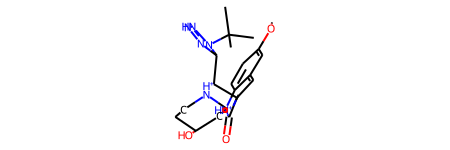

In [10]:
m1

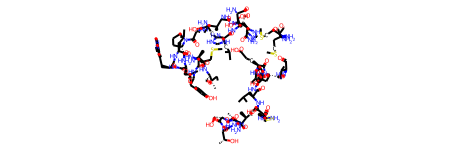

In [11]:
m2

In [1]:
import numpy as np
a = list(np.arange(100))
np.random.shuffle(a)

In [3]:
5000

1.3888888888888888

In [10]:
a,b,c,d = [1,1,0,0]

In [1]:
import torch
torch.einsum??

Signature: torch.einsum(equation, *operands)
Source:   
def einsum(equation, *operands):
    r"""einsum(equation, *operands) -> Tensor

    Sums the product of the elements of the input :attr:`operands` along dimensions specified using a notation
    based on the Einstein summation convention.

    Einsum allows computing many common multi-dimensional linear algebraic array operations by representing them
    in a short-hand format based on the Einstein summation convention, given by :attr:`equation`. The details of
    this format are described below, but the general idea is to label every dimension of the input :attr:`operands`
    with some subscript and define which subscripts are part of the output. The output is then computed by summing
    the product of the elements of the :attr:`operands` along the dimensions whose subscripts are not part of the
    output. For example, matrix multiplication can be computed using einsum as `torch.einsum("ij,jk->ik", A, B)`.
    Here, j is the 

In [16]:
len([None,1,0,None])

4

In [13]:
with open('/home/chengeng/project/codes/GNN_graphformer/keys/test.txt','r')as f:
    test_dude_gene = f.readlines()

0

In [2]:
next??

Docstring:
next(iterator[, default])

Return the next item from the iterator. If default is given and the iterator
is exhausted, it is returned instead of raising StopIteration.
Type:      builtin_function_or_method


In [1]:
from torch.utils.data import DataLoader                                     
from graphformer_dataset import graphformerDataset, collate_fn, DTISampler

In [3]:
train_weights = [0.1,0.2,0.2,0.3,0.2]
train_sampler = DTISampler(train_weights, len(train_weights), replacement=True)                     
train_dataloader = DataLoader([1,2,3,4,5], 5, \
    shuffle=False,\
    sampler = train_sampler)#动态采样

In [4]:
for i in range(10):
    for data in train_dataloader:
        print(data)

tensor([1, 4, 2, 3, 3])
tensor([4, 4, 5, 2, 4])
tensor([4, 2, 2, 5, 4])
tensor([4, 2, 5, 2, 4])
tensor([3, 2, 2, 2, 5])
tensor([4, 2, 3, 5, 5])
tensor([5, 2, 4, 1, 5])
tensor([5, 5, 5, 4, 5])
tensor([4, 3, 1, 1, 5])
tensor([5, 5, 4, 3, 3])


In [2]:
import torch
import numpy as np

In [3]:
y_pred = torch.tensor(np.random.randn(10))

In [4]:
labels =torch.tensor([0,1,1,0,0,0,0,1,1,1])

In [12]:
pos_num = torch.sum(labels)
neg_num = len(labels) - pos_num
pos_pred = y_pred[labels.bool()]
neg_pred = y_pred[(1-labels).bool()]


In [13]:
pos_pred

tensor([ 0.1723, -0.0048,  0.5465, -0.2397, -1.3048], dtype=torch.float64)

In [19]:
torch.sum(neg_pred-pos_pred.reshape(-1,1))/25

tensor(-0.4857, dtype=torch.float64)

In [ ]:
def forward(self, x, labels=None):
    x1, attn_weights1,hidden_state1 = self.transformer(x)

    logits = self.head(x1[:, 0])

    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))

        x2, attn_weights2,hidden_state2 = self.transformer(x)
        newlogits = self.head(x2[:, 0])
        loss2 = loss_fct(newlogits.view(-1, self.num_classes), labels.view(-1))
        loss+=loss2
        
        
        p = torch.log_softmax(logits.view(-1, self.num_classes), dim=-1)
        p_tec = torch.softmax(logits.view(-1, self.num_classes), dim=-1)
        q = torch.log_softmax(newlogits.view(-1, self.num_classes), dim=-1)
        q_tec = torch.softmax(newlogits.view(-1, self.num_classes), dim=-1)
        kl_loss = torch.nn.functional.kl_div(p, q_tec, reduction='none').sum()
        reverse_kl_loss = torch.nn.functional.kl_div(q, p_tec, reduction='none').sum()


        loss += self.alpha * (kl_loss + reverse_kl_loss)

        return loss
    else:
        return logits, attn_weights1

In [ ]:
def train(model,args,optimizer,loss_fn,train_dataloader,auxiliary_loss):
# 加入辅助函数和r_drop 方式
            #collect losses of each iteration
            train_losses = [] 
            train_true = []
            train_pred = []
            model.train()
            if args.r_drop:
                for i_batch, sample in enumerate(train_dataloader):
                    model.zero_grad()
                
                    data_flag,data = data_to_device(sample,args.device)
                    logits = model(args.A2_limit,data_flag,*data)
                    newlogits = model(args.A2_limit,data_flag,*data)
                    # logits = 

                    if args.loss_fn == 'bce_loss':
                        pred  = torch.sigmoid(logits[:,1])
                        pred = pred.view(-1)
                        # loss = loss_fn(pred, sample.Y.to(pred.device))
                        pred_1 = torch.sigmoid(newlogits[:,1])
                        pred_1 = pred_1.view(-1)
                        # loss += loss_fn(pred_1, sample.Y.to(pred.device))
                        loss = loss_fn(pred, sample.Y.to(pred.device))
                        loss += loss_fn(pred_1, sample.Y.to(pred.device))
                    else:
                        loss = loss_fn(logits, sample.Y.to(pred.device))
                        loss += loss_fn(newlogits, sample.Y.to(pred.device))
                
                    # kl div
                    p = torch.log_softmax(logits.view(-1,2), dim=-1)
                    p_tec = torch.softmax(logits.view(-1,2), dim=-1)
                    q = torch.log_softmax(newlogits.view(-1,2), dim=-1)
                    q_tec = torch.softmax(newlogits.view(-1,2), dim=-1)
                    kl_loss = torch.nn.functional.kl_div(p, q_tec, reduction='none').sum()
                    reverse_kl_loss = torch.nn.functional.kl_div(q, p_tec, reduction='none').sum()
                    #------------------------
                    alpha = 5
                    loss += alpha*(kl_loss + reverse_kl_loss)/2
                    if args.auxiliary_loss:
                        loss = loss  + model.deta*auxiliary_loss(pred,sample.Y.to(pred.device))


                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.data.cpu().numpy())
                    train_true.append(sample.Y.data.cpu().numpy())
                    if pred.dim() ==2:
                        pred = torch.softmax(pred,dim = -1)[:,1]
                    train_pred.append(pred.data.cpu().numpy())
            else:

                for i_batch, sample in enumerate(train_dataloader):
                    model.zero_grad()
                
                    data_flag,data = data_to_device(sample,args.device)
                    pred = model(args.A2_limit,data_flag,*data)
                    loss = loss_fn(pred, sample.Y.to(pred.device))
                    if args.auxiliary_loss:
                        loss += model.deta*auxiliary_loss(pred,sample.Y.to(pred.device))
                    
                        # loss = loss_fn(pred, sample.Y.to(pred.device))
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.data.cpu().numpy())
                    train_true.append(sample.Y.data.cpu().numpy())
                    if pred.dim() ==2:
                        pred = torch.softmax(pred,dim = -1)[:,1]
                    train_pred.append(pred.data.cpu().numpy())
                return model,train_pred,train_losses,optimizer

In [42]:
import torch
import numpy as np
x = torch.softmax(torch.tensor(np.random.uniform(10)).reshape(-1,1),dim = -1)
y  = torch.softmax(torch.tensor(np.random.rand(10)).reshape(-1,1),dim = -1)
pred = torch.cat([x,1-x],dim = 1)
target = torch.cat([y,1-y],dim = 1)
torch.nn.functional.kl_div(pred,target,log_target=True)

/home/caoduanhua/anaconda3/envs/pignet/lib/python3.6/site-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(0., dtype=torch.float64)

In [38]:
torch.nn.functional.kl_div(pred,target)

tensor(-0.5000, dtype=torch.float64)

In [39]:
torch.nn.functional.kl_div(pred[:,0],target[:,0])

tensor(-1., dtype=torch.float64)

In [40]:
pred

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=torch.float64)